##1. Tasks

### 1. Raw image -> tfrecords -> Save -> Retrieve tfrecord -> Training & Validation
Done
### 2. Instead of saving tfrecords file locally, save it to google drive and retrieve from there and use for training   
Prerequisite before run : create below folder structure in google drive
- {My Drive}/datasets/tfrecords/cifar10/preprocessed/  

### 3. Raw image -> Apply Norm & Pad -> tfrecords -> Save -> Retrieve tfrecord -> Training & Validation

### 4. Raw image -> Apply Norm & Pad -> Apply ImgAug - > tfrecords -> Save -> Retrieve tfrecord -> Training & Validation

##2. Imports

In [0]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

import os, sys
from six.moves import cPickle as pickle

from google.colab import drive

drive.mount('/gdrive')

!ls "/gdrive/My Drive/datasets/tfrecords/cifar10/preprocessed"

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
test.tfrecords	train.tfrecords


###2.1 Enable Eager mode of execution

In [0]:
tf.enable_eager_execution()
print("Tensorflow Version : ", tf.__version__)


Tensorflow Version :  1.15.0


##3. Hyperparameters initialization

In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

##4. Deterministic init of Weights

In [0]:
# for deterministic initialization of kernel weights
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

##5. Model Architecture

In [0]:
# Conv2D and BatchNormalization
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
# basic ResNet block
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
# DavidNet architecture that follows ResNet
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
#     comp1 = tf.argmax(h, axis =1)
#     comp2 = y
#     print("....................................... comp1.type = ", type(comp1))
#     print("....................................... comp2.type = ", type(comp2))
#     print("....................................... comp1.dtype = ", comp1.dtype)
#     print("....................................... comp2.dtype = ", comp2.dtype)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

##6. Dataset

###6.1 Download Dataset

In [0]:
#Get Dataset
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train_orig), len(x_test_orig)
y_train_orig = y_train_orig.astype('int64').reshape(len_train)
y_test_orig = y_test_orig.astype('int64').reshape(len_test)

train_mean = np.mean(x_train_orig, axis=(0,1,2))
train_std = np.std(x_train_orig, axis=(0,1,2))


In [0]:
# for debug
!pwd
print("x_train_orig.type() - ", type(x_train_orig))
#print("x_train_orig.dir() - ", dir(x_train_orig))
print("x_train_orig.ndim - ", x_train_orig.ndim)
print("x_train_orig.shape - ", x_train_orig.shape)
print("x_train_orig.size - ", x_train_orig.size)
print("x_train_orig.dtype - ", np.dtype(x_train_orig[0][0][0][0]))
print("len_train =", len_train)
print()
print("y_train_orig.type() - ", type(y_train_orig))
#print("y_train_orig.dir() - ", dir(y_train_orig))
print("y_train_orig.ndim - ", y_train_orig.ndim)
print("y_train_orig.shape - ", y_train_orig.shape)
print("y_train_orig.size - ", y_train_orig.size)
print("y_train_orig.dtype - ", np.dtype(y_train_orig[0]))
print("len_test =", len_test)

/content
x_train_orig.type() -  <class 'numpy.ndarray'>
x_train_orig.ndim -  4
x_train_orig.shape -  (50000, 32, 32, 3)
x_train_orig.size -  153600000
x_train_orig.dtype -  uint8
len_train = 50000

y_train_orig.type() -  <class 'numpy.ndarray'>
y_train_orig.ndim -  1
y_train_orig.shape -  (50000,)
y_train_orig.size -  50000
y_train_orig.dtype -  int64
len_test = 10000


In [0]:
#Normalization and padding
normalize = lambda x: ((x - train_mean) / train_std).astype('float32') 
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train_orig = normalize(pad4(x_train_orig))
x_test_orig = normalize(x_test_orig)

###6.2 Prepare TF records

Table :

------------------------------------------------------

|       | Output files    | Lengths   | Input        | Output        |
|---    |---              |---        |---           |---            |
|train  | train.tfrecords | len_train | x_train_orig | y_train_orig  |
|test   |  test.tfrecords | len_test  | x_test_orig  | y_test_orig   |

In [0]:
#conversion sequence
#dataset -> list -> feature -> example -> ToString -> write to file as tfrecord
def int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def float32_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value.reshape(-1))) # check this, whether .reshape(-1) is needed or not

def bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


output_files = {'train': 'train.tfrecords', 'test': 'test.tfrecords'}
lengths = {'train': len_train, 'test': len_test}
input_data = {'train': x_train_orig, 'test': x_test_orig}
output_data = {'train': y_train_orig, 'test': y_test_orig}
def prepare_tf_records(mode):
  with tf.python_io.TFRecordWriter(output_files[mode]) as record_writer:
    num_entries = lengths[mode]
    data = input_data[mode]
    labels = output_data[mode]
    print('num_entries = ', num_entries)
    for i in range(num_entries):
      one_image = data[i,::]
      one_label = labels[i]
      #image_size = one_image.shape[0]
      example = tf.train.Example(features=tf.train.Features(
          feature={
              'image': float32_feature(one_image), # check this, whether tobytes is needed or not
              'label': int64_feature(one_label)
          }))
      record_writer.write(example.SerializeToString()) # SerializeToString is very important
    
prepare_tf_records('train')
prepare_tf_records('test')


num_entries =  50000
num_entries =  10000


In [0]:
#for debug
data = input_data['train']
print("data.type() - ", type(data))
print("data.ndim - ", data.ndim)
print("data.shape - ", data.shape)
print("data.size - ", data.size)
print("data.dtype - ", np.dtype(data[0][0][0][0]))

one_image = data[0,::]
print("one_image.shape - ", one_image.shape)
print("one_image.shape - ", one_image.shape[0])

data.type() -  <class 'numpy.ndarray'>
data.ndim -  4
data.shape -  (50000, 40, 40, 3)
data.size -  240000000
data.dtype -  float32
one_image.shape -  (40, 40, 3)
one_image.shape -  40


In [0]:
#for debug
!ls /content -l
!ls "/gdrive/My Drive/datasets/tfrecords/cifar10/preprocessed"

total 1060920
drwxr-xr-x 1 root root      4096 Oct 25 16:58 sample_data
-rw-r--r-- 1 root root 123420000 Nov  1 05:39 test.tfrecords
-rw-r--r-- 1 root root 962950000 Nov  1 05:38 train.tfrecords
test.tfrecords	train.tfrecords


In [0]:
!cp /content/train.tfrecords "/gdrive/My Drive/datasets/tfrecords/cifar10/preprocessed/."
!cp /content/test.tfrecords "/gdrive/My Drive/datasets/tfrecords/cifar10/preprocessed/."

!cp "/gdrive/My Drive/datasets/tfrecords/cifar10/preprocessed/train.tfrecords" /opt/
!cp "/gdrive/My Drive/datasets/tfrecords/cifar10/preprocessed/test.tfrecords" /opt/

###6.3 Retrieve TF records

In [0]:
#tfrecords file -> tfrecordDataset -> features -> image, label
#parser works on given input(tfrecords file), similar to an apple cutter on a given apple
def parser(serialized_example, img_sz):
  """Parses a single tf.Example into image and label tensors."""
  # Dimensions of the images in the CIFAR-10 dataset.
  # See http://www.cs.toronto.edu/~kriz/cifar.html for a description of the
  # input format.
  parsed_example = tf.parse_single_example(
      serialized = serialized_example,
      features = {
          'image': tf.FixedLenFeature([img_sz*img_sz*3], tf.float32),
          'label': tf.FixedLenFeature([], tf.int64),
      })
  
  #image = parsed_example['image']
  #image = tf.sparse_tensor_to_dense(parsed_example['image'], default_value=0)

  image = tf.cast(
      tf.reshape(parsed_example['image'], [img_sz, img_sz, 3]),
      tf.float32)
  label = tf.cast(parsed_example['label'], tf.int64)

  # Custom preprocessing.
  #image = self.preprocess(image)

  return image, label


def read_tf_records(mode, file_name, image_size):
  # Create a list of filenames and pass it to a queue
  file_names = [file_name]
  raw_dataset = tf.data.TFRecordDataset(file_names)
  lambda x: fun(x, my_arg)
  parsed_image_dataset = raw_dataset.map(lambda x: parser(x, image_size))
  ####################################
  print("parsed_image_dataset.type() - ", type(parsed_image_dataset))
  print("x_train_orig.dir - ", dir(parsed_image_dataset))
  print("x_train_orig.output_classes - ", tf.compat.v1.data.get_output_classes(parsed_image_dataset))
  print("x_train_orig.output_shapes - ", tf.compat.v1.data.get_output_shapes(parsed_image_dataset))
  print("x_train_orig.output_types - ", tf.compat.v1.data.get_output_types(parsed_image_dataset))
  ####################################
  x = []
  y = []
  for image_features in parsed_image_dataset:
    x.append(image_features[0].numpy()) #image (EagerTensor to numpy array)
    y.append(image_features[1].numpy()) #label (EagerTensor to numpy array)
  print("x.type() - ", type(x))

  x = np.asarray(x) #(numpy array to ndarray)
  y = np.asarray(y) #(numpy array to ndarray)
  return x, y

x_train, y_train = read_tf_records('train', '/opt/train.tfrecords', 40)
x_test, y_test = read_tf_records('test', '/opt/test.tfrecords', 32)




parsed_image_dataset.type() -  <class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>
x_train_orig.dir -  ['_GeneratorState', '__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_add_variable_with_custom_getter', '_apply_options', '_as_serialized_graph', '_as_variant_tensor', '_checkpoint_dependencies', '_component_metadata', '_consumers', '_dataset', '_deferred_dependencies', '_flat_shapes', '_flat_structure', '_flat_types', '_from_components', '_functions', '_gather_saveables_for_checkpoint', '_graph', '_graph_attr', '_handle_deferred_dependencies', '_has_captured_r

In [0]:
# for debug
print("x_train.type() - ", type(x_train))
#print("x_train.dir() - ", dir(x_train))
print("x_train.ndim - ", x_train.ndim)
print("x_train.shape - ", x_train.shape)
print("x_train.size - ", x_train.size)
print("len(x_train) = ", len(x_train))

print()
print("y_train.type() - ", type(y_train))
#print("y_train.dir() - ", dir(y_train))
print("y_train.ndim - ", y_train.ndim)
print("y_train.shape - ", y_train.shape)
print("y_train.size - ", y_train.size)
print("len(y_train) = ", len(y_train))

x_train.type() -  <class 'numpy.ndarray'>
x_train.ndim -  4
x_train.shape -  (50000, 40, 40, 3)
x_train.size -  240000000
len(x_train) =  50000

y_train.type() -  <class 'numpy.ndarray'>
y_train.ndim -  1
y_train.shape -  (50000,)
y_train.size -  50000
len(y_train) =  50000


###6.4 Sample display of images

sample_data  test.tfrecords  train.tfrecords


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

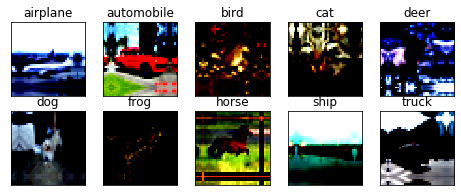

In [0]:
#Verify whether dataset is proper
import matplotlib.pyplot as plt
!ls
# print("\nlen(x_test) = ", len(x_test))
# print("len(y_test) = ", len(y_test))
#print("(y_train) = ", (y_train))

#import IPython.display as display
#display.display(display.Image(data=x_test[0,::]))

num_classes = 10
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()


###6.5 Data Preprocessing

Pictorial representaion of One-Cycle-LR configuration

>>>>$ (A_{2},B_{2}) $    


   
                   |
                   .
                  .  .
                 .     .
                .        .
               .           .
              .              .
             .                 .
            .                    .
           .                       .
          .                          .
         .                             .
        .                                .
       .                                   .
      .                                      .
     ........................................... 
     |                                         |
            
>$ (A_{1},B_{1}) $ 
>>>>>>>>>>>$ (A_{3},B_{3}) $  


X - axis is epoch number  
Y - axis is LR(learning rate)

In [0]:
#Image Augmentation and One-Cycle-LR 

batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0] #[A1, A2, A3], [B1, B2, B3] vide pictorial representation in above cell
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)

##7. Model instantiation

In [0]:
model = DavidNet() # model instance creation where constructor(__init__) will be invoked

##8. Training and Validation on Model

In [0]:
#Validate whether currently executing in eager mode or not
tf.executing_eagerly()

True

In [0]:
t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)
  #print("During Training")
  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y) # model invokation where call method will be invoked

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()
  #print("During Inferencing")
  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
    
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


epoch: 1 lr: 0.08 train loss: 1.5778555041503906 train acc: 0.43048 val loss: 1.1912531616210937 val acc: 0.5867 time: 82.98989176750183



epoch: 2 lr: 0.16 train loss: 0.839266157836914 train acc: 0.70486 val loss: 0.9690409790039063 val acc: 0.6628 time: 150.58214354515076



epoch: 3 lr: 0.24 train loss: 0.6427421282958984 train acc: 0.7767 val loss: 0.6291569046020508 val acc: 0.7823 time: 217.4121663570404



epoch: 4 lr: 0.32 train loss: 0.5442836901855469 train acc: 0.81308 val loss: 0.6582555206298828 val acc: 0.7688 time: 284.30366253852844



epoch: 5 lr: 0.4 train loss: 0.4873892248535156 train acc: 0.83232 val loss: 0.5604690139770507 val acc: 0.8054 time: 351.27308201789856



epoch: 6 lr: 0.37894736842105264 train loss: 0.39993513854980467 train acc: 0.86132 val loss: 0.5188676742553711 val acc: 0.8212 time: 418.28618144989014



epoch: 7 lr: 0.35789473684210527 train loss: 0.32301013061523437 train acc: 0.88686 val loss: 0.5240120849609375 val acc: 0.8253 time: 485.80086040496826



epoch: 8 lr: 0.33684210526315794 train loss: 0.26688065399169925 train acc: 0.90778 val loss: 0.401638126373291 val acc: 0.8645 time: 553.511848449707



epoch: 9 lr: 0.31578947368421056 train loss: 0.23054593887329103 train acc: 0.91908 val loss: 0.41204088287353513 val acc: 0.8689 time: 620.9435079097748



epoch: 10 lr: 0.2947368421052632 train loss: 0.199721007232666 train acc: 0.9317 val loss: 0.4214031379699707 val acc: 0.8662 time: 688.816504240036



epoch: 11 lr: 0.2736842105263158 train loss: 0.17617345664978026 train acc: 0.93932 val loss: 0.41120429229736327 val acc: 0.8701 time: 758.0007677078247



epoch: 12 lr: 0.25263157894736843 train loss: 0.15047654418945314 train acc: 0.94844 val loss: 0.3630588142395019 val acc: 0.8858 time: 826.9065351486206



epoch: 13 lr: 0.23157894736842108 train loss: 0.12984175636291503 train acc: 0.9553 val loss: 0.3010556625366211 val acc: 0.9046 time: 895.9912421703339



epoch: 14 lr: 0.2105263157894737 train loss: 0.11092958671569825 train acc: 0.9621 val loss: 0.30743345336914063 val acc: 0.9071 time: 964.6396849155426



epoch: 15 lr: 0.18947368421052635 train loss: 0.09490788593292236 train acc: 0.96822 val loss: 0.3314678024291992 val acc: 0.9037 time: 1033.363798379898



epoch: 16 lr: 0.16842105263157897 train loss: 0.0826182434463501 train acc: 0.97188 val loss: 0.3812435218811035 val acc: 0.8918 time: 1101.851425409317



epoch: 17 lr: 0.1473684210526316 train loss: 0.0665573413658142 train acc: 0.97726 val loss: 0.2835726627349853 val acc: 0.9158 time: 1170.2326529026031



epoch: 18 lr: 0.12631578947368421 train loss: 0.05352604846954346 train acc: 0.9826 val loss: 0.27723515014648437 val acc: 0.9209 time: 1238.7024796009064



epoch: 19 lr: 0.10526315789473689 train loss: 0.0457233131980896 train acc: 0.98614 val loss: 0.26777942199707033 val acc: 0.9238 time: 1306.5389215946198



epoch: 20 lr: 0.08421052631578951 train loss: 0.03677524375915527 train acc: 0.98914 val loss: 0.29106089782714845 val acc: 0.9228 time: 1375.0042338371277



epoch: 21 lr: 0.06315789473684214 train loss: 0.032423664112091063 train acc: 0.99056 val loss: 0.26663012619018556 val acc: 0.9253 time: 1442.7215616703033



epoch: 22 lr: 0.04210526315789476 train loss: 0.026806707820892332 train acc: 0.99304 val loss: 0.2575359970092773 val acc: 0.9284 time: 1510.39804148674



epoch: 23 lr: 0.02105263157894738 train loss: 0.023877275381088258 train acc: 0.99406 val loss: 0.2571772155761719 val acc: 0.9294 time: 1577.8618612289429



epoch: 24 lr: 0.0 train loss: 0.020296592869758608 train acc: 0.9953 val loss: 0.2563658866882324 val acc: 0.9291 time: 1645.6127753257751
